In [67]:
 # De ley
import pandas as pd 
import numpy as np 
from datetime import date

#Normalizacion de palabras 
from thefuzz import fuzz, process

# Graficos 
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

#prepocesamiento de datos
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
import category_encoders as ce


# division entranamiento-validacion
from sklearn.model_selection import train_test_split 
#clustering 
from sklearn.cluster import KMeans

# Funciones

In [68]:
def tabla_frecuencias(df,col):
    #construir una tabla de frecuencias. 
    
    rating_counts = (df.groupby(col).agg(frec_absoluta=(col, "count"))).sort_values(['frec_absoluta'], ascending = False)
    
    rating_counts["frec_absoluta_acumulada"] = rating_counts["frec_absoluta"].cumsum()

    
    rating_counts['frec_relativa'] = rating_counts['frec_absoluta'].apply(lambda x: x/rating_counts['frec_absoluta'].sum())
    rating_counts['frec_relativa(%)'] = rating_counts['frec_relativa'].apply(lambda x: x*100 )

    
    
    rating_counts['frec_relativa_acumulada'] = rating_counts['frec_absoluta_acumulada'].apply(lambda x: x/rating_counts['frec_absoluta'].sum())  
    rating_counts['frec_relativa_acumulada(%)'] = rating_counts['frec_relativa_acumulada'].apply(lambda x: x*100)
    
    return rating_counts

In [69]:
def tabla_intervalo_frecuencias(df,col,long_intervalos):
    #construir una tabla de frecuencias. 
    aux = df
    bins = list(range(int(min(df[col])),int(max(df[col]))+1,long_intervalos))

    aux["intervalos"] = pd.cut(df[col], bins=bins)


    rating_counts = (df.groupby("intervalos").agg(frec_absoluta=(col, "count")))
    
    rating_counts["frec_absoluta_acumulada"] = rating_counts["frec_absoluta"].cumsum()

    
    rating_counts['frec_relativa'] = rating_counts['frec_absoluta'].apply(lambda x: x/rating_counts['frec_absoluta'].sum())
    rating_counts['frec_relativa(%)'] = rating_counts['frec_relativa'].apply(lambda x: x*100 )

    
    
    rating_counts['frec_relativa_acumulada'] = rating_counts['frec_absoluta_acumulada'].apply(lambda x: x/rating_counts['frec_absoluta'].sum())  
    rating_counts['frec_relativa_acumulada(%)'] = rating_counts['frec_relativa_acumulada'].apply(lambda x: x*100)

    
    return rating_counts

In [70]:
def conv(x):
    meses = {'enero':'01','febrero':'02','marzo':'03','abril':'04','mayo':'05','junio':'06','julio':'07','agosto':'08',
            'septiembre':'09','octubre':'10','noviebre':'11','diciembre':'12'}
    if x == None:
        return 0
    for mes in meses:
        if mes == x:
            return meses[x]

In [71]:
def con_categ_to_columns(df,col,col_fecha):
    data = pd.DataFrame({})
    uniques = df[col].unique()
    df = df[[col_fecha,col]]
    for unique in uniques:
        aux = df[df[col] == unique]
        aux2 = (aux.groupby(col_fecha).agg(count=(col, "count"))).sort_values([col_fecha], ascending = True)
        data[unique] = aux2['count'] 
    data['fecha'] = aux2.index
    return data

In [72]:
def hora2(x):
    try:
        x = str(x)
        x1 = x[:x.index(':')+1].replace(':','.')
        x2 = x[x.index(':')+1:].replace(':','')
        x = x1 + x2
        x = float(x)
        return round(x)
        
    except:
        return '0'

In [73]:
def hora(x):
    normalizar = {12:12,1:13,2:14,3:15,4:16,5:17,6:18,7:19,8:20,9:21,10:22,11:23}
    if x == None:
        return 'DESC'
    
    else:
        x = str(x)
        try:
            x = str(x)
            x1 = x[:x.index(':')+1].replace(':','.')
            x2 = x[x.index(':')+1:].replace(':','')
            x = x1 + x2
            if 'p' in x:
                x = x.split('p')[0]
                x = float(x)
                ent = int(x)
                dec = x - ent
                x = normalizar[ent] + dec
                if 12.00 <= x and x < 19.00:
                    return 'TARDE'
                elif 19.00 <= x and x <= 23.59:
                    return 'NOCHE'
            else:
                x = x.split('a')[0]
                x = float(x)
                ent = int(x)
                dec = x - ent
                x = normalizar[ent] + dec
                if 12 <= x and x < 18.00:
                    return 'MADRUGADA'
                elif  18 <= x and x <= 23.59:
                    return 'MAÑANA'
        except:
            return '0'

# TRATAMIENTO

In [74]:
ruta_git = 'https://raw.githubusercontent.com/RiemanNClav/Hechos-de-Transito-registrados-por-la-SSC/master/hechos_transito.csv'
ruta_local = 'C:/Users/XMX5634/Documents/Hechos-de-Transito-registrados-por-la-SSC/hechos_transito.csv'
df = pd.read_csv(ruta_local)

C:\Users\XMX5634\AppData\Local\Temp/ipykernel_20404/1823139733.py:3: DtypeWarning: Columns (4,16,17,18,19,20,32,36,41,42,43,44,45,47,49,50,51,52,53,54,66,67,68) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_local)


In [75]:
df.shape

(107882, 69)

In [76]:
df.isnull().sum()/len(df)*100

no_folio                  0.000927
fecha_evento              0.000000
mes                       0.000000
hora                      0.027808
condicion                67.517287
                           ...    
conductor_occiso         32.482713
conductor_lesionado      32.482713
diagnostico_occiso       98.764391
diagnostico_lesionado    33.404090
origen                   32.482713
Length: 69, dtype: float64

In [77]:
dict(zip(df.dtypes.index,df.dtypes.values))

{'no_folio': dtype('O'),
 'fecha_evento': dtype('O'),
 'mes': dtype('O'),
 'hora': dtype('O'),
 'condicion': dtype('O'),
 'tipo_de_evento': dtype('O'),
 'coordenada_x': dtype('float64'),
 'coordenada_y': dtype('float64'),
 'punto_1': dtype('O'),
 'punto_2': dtype('O'),
 'colonia': dtype('O'),
 'alcaldia': dtype('O'),
 'tipo_de_interseccion': dtype('O'),
 'tipo_de_vehiculo_1': dtype('O'),
 'tipo_de_vehiculo_2': dtype('O'),
 'tipo_de_vehiculo_3': dtype('O'),
 'marca_de_vehiculo_1': dtype('O'),
 'marca_de_vehiculo_2': dtype('O'),
 'marca_de_vehiculo_3': dtype('O'),
 'lesiones': dtype('O'),
 'edad_occiso': dtype('O'),
 'edad_lesionado': dtype('O'),
 'se_desconoce_occiso': dtype('int64'),
 'se_desconoce_lesionado': dtype('int64'),
 'total_occisos': dtype('int64'),
 'occisos_femeninos': dtype('int64'),
 'occisos_masculinos': dtype('int64'),
 'occiso_se_desconoce': dtype('int64'),
 'total_lesionados': dtype('int64'),
 'lesionados_femeninos': dtype('int64'),
 'lesionados_masculinos': dtype('in

In [78]:
dicc1 = {}
dicc2 = {}
for id_ in df.fillna({'identidad':'desconocido'}).identidad.unique():
    dicc1[id_] = len(id_.split(' '))
    dicc2[id_] = id_.split(' ')
    
print('la longitud maxima es de ' +str(len(dicc2[max(dicc1, key=dicc1.get)]))+': '+ max(dicc1, key=dicc1.get))

la longitud maxima es de 5: CONDUCTOR PASAJERO PASAJERO PASAJERO PASAJERO


In [79]:
def f_columns(df,col_name):
    dicc1 = {}
    df = df.fillna({col_name:'desconocido'})
    aux = [x.split(' ') for x in df[col_name].unique()]
    max_ = max(len(x) for x in aux)
    
    i=0
    for lista in aux:
        while len(lista) < max_:
            lista.append(None)
        dicc1[df[col_name].unique()[i]] = lista
        i+=1
        
    df['aux'] = df['identidad'].map(dicc1)
    df['len_aux'] = df['aux'].apply(lambda x: len(x))
    df['len_identidad'] = df['identidad'].apply(lambda x: len(x.split(' ')))
    
    for i in range(max_):
        df[col_name+str(i+1)] = df['aux'].apply(lambda x: x[i])

    return df[['identidad','len_identidad','aux','len_aux','identidad1','identidad2','identidad3','identidad4','identidad5']]

In [80]:
def f2_columns(df,col_name):
    dicc1 = {}
    df = df.fillna({col_name:'desconocido'})
    aux = [x.split(' ') for x in df[col_name].unique()]
    max_ = max(len(x) for x in aux)
    
    i=0
    for lista in aux:
        while len(lista) < max_:
            lista.append(None)
        dicc1[df[col_name].unique()[i]] = lista
        i+=1
        
    df['aux'] = df['identidad'].map(dicc1)
    df['len_aux'] = df['aux'].apply(lambda x: len(x))
    df['len_identidad'] = df['identidad'].apply(lambda x: len(x.split(' ')))
    
    for i in range(max_):
        df[col_name+str(i+1)] = df['aux'].apply(lambda x: x[i])

    return df

In [81]:
dicc1 = {}
df = df.fillna({'identidad':'DESCONOCIDO'})
aux = [x.split(' ') for x in df['identidad'].unique()]
max_ = max(len(x) for x in aux)
    
i=0
for lista in aux:
    while len(lista) < max_:
        lista.append(None)
    dicc1[df['identidad'].unique()[i]] = lista
    i+=1
        
df['aux'] = df['identidad'].map(dicc1)
df['len_aux'] = df['aux'].apply(lambda x: len(x))
df['len_identidad'] = df['identidad'].apply(lambda x: len(x.split(' ')))

for i in range(max_):
    df['identidad'+str(i+1)] = df['aux'].apply(lambda x: x[i])

In [82]:
cases = []

### len_identidad == 1

In [83]:
len_ = 1
case = df[df['len_identidad'] == len_]

In [84]:
case["occisos_fem"] = np.where(case.occisos_femeninos > 0,case.identidad1,None)
case["occisos_masc"] = np.where(case.occisos_masculinos > 0,case.identidad1,None)
case["occisos_desc"] = np.where(case.occiso_se_desconoce > 0,case.identidad1,None)
        # ----------------------------------------------------------------------------------
case["lesionados_fem"] = np.where(case.lesionados_femeninos > 0,case.identidad1,None)
case["lesionados_masc"] = np.where(case.lesionados_masculinos > 0,case.identidad1,None)
case["lesionados_desc"] = np.where(case.lesionado_se_desconoce > 0,case.identidad1,None)

C:\Users\XMX5634\AppData\Local\Temp/ipykernel_20404/3419861311.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case["occisos_fem"] = np.where(case.occisos_femeninos > 0,case.identidad1,None)
C:\Users\XMX5634\AppData\Local\Temp/ipykernel_20404/3419861311.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case["occisos_masc"] = np.where(case.occisos_masculinos > 0,case.identidad1,None)
C:\Users\XMX5634\AppData\Local\Temp/ipykernel_20404/3419861311.py:3: SettingWithCopyWarning: 
A value is trying to be se

In [85]:
cases.append(case)

### len_identidad == 2

In [86]:
len_ = 2
case = df[df['len_identidad'] == len_]

In [87]:
condiciones_occisos_fem = [(case.total_occisos == 2) & (case.occisos_femeninos == len_),
                            (case.total_occisos == 2) & (case.occisos_femeninos == 1),
                            (case.total_occisos == 1) & (case.occisos_femeninos == 1)
                           ]
elecciones_occisos_fem = np.array((case.identidad,case.identidad1,case.identidad1,), dtype="object")


condiciones_occisos_masc = [(case.total_occisos == 2) & (case.occisos_masculinos == len_),
                            (case.total_occisos == 2) & (case.occisos_masculinos == 1),
                            (case.total_occisos == 1) & (case.occisos_masculinos == 1)
                           ]
elecciones_occisos_masc = np.array((case.identidad,case.identidad2,case.identidad1), dtype="object")


condiciones_occisos_desc = [(case.total_occisos == 2) & (case.occiso_se_desconoce == len_),
                   (case.total_occisos == 2) & (case.occiso_se_desconoce == 1),
                   (case.total_occisos == 1) & (case.occiso_se_desconoce == 1)
                   ]
elecciones_occisos_desc = np.array((case.identidad,case.identidad2,case.identidad1), dtype="object")

In [88]:
case["occisos_fem"] = np.select(condiciones_occisos_fem, elecciones_occisos_fem, None)
case["occisos_masc"] = np.select(condiciones_occisos_masc, elecciones_occisos_masc, None)
case["occisos_desc"] = np.select(condiciones_occisos_desc, elecciones_occisos_desc, None) 

C:\Users\XMX5634\AppData\Local\Temp/ipykernel_20404/1727391636.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case["occisos_fem"] = np.select(condiciones_occisos_fem, elecciones_occisos_fem, None)
C:\Users\XMX5634\AppData\Local\Temp/ipykernel_20404/1727391636.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case["occisos_masc"] = np.select(condiciones_occisos_masc, elecciones_occisos_masc, None)
C:\Users\XMX5634\AppData\Local\Temp/ipykernel_20404/1727391636.py:3: SettingWithCopyWarning: 
A value is 

In [89]:
condiciones_lesionados_fem = [(case.total_occisos == 0) & (case.lesionados_femeninos == 2),
                              (case.total_occisos == 0) & (case.lesionados_femeninos == 1),
                              (case.total_occisos == 1) & (case.lesionados_femeninos == 1),
                             ]
elecciones_lesionados_fem = np.array((case.identidad,case.identidad1,case.identidad2), dtype="object")


condiciones_lesionados_masc = [(case.total_occisos == 0) & (case.lesionados_masculinos == 2),
                               (case.total_occisos == 0) & (case.lesionados_femeninos == 1) & (case.lesionados_masculinos == 1),
                               (case.total_occisos == 0) & (case.lesionados_femeninos == 0) & (case.lesionados_masculinos == 1),
                               (case.total_occisos == 1) & (case.lesionados_masculinos == 1)
                              ]
elecciones_lesionados_masc = np.array((case.identidad,case.identidad2,case.identidad1,case.identidad2), dtype="object")


condiciones_lesionados_desc = [(case.total_occisos == 0) & (case.lesionado_se_desconoce == 2),
                               (case.total_occisos == 0) & (case.lesionados_femeninos == 1) & (case.lesionado_se_desconoce == 1),
                               (case.total_occisos == 0) & (case.lesionados_masculinos == 1) & (case.lesionado_se_desconoce == 1),
                               (case.total_occisos == 1) & (case.lesionado_se_desconoce == 1),
                              ]
elecciones_lesionados_desc = np.array((case.identidad,case.identidad2,case.identidad2,case.identidad2), dtype="object")

In [90]:
case["lesionados_fem"] = np.select(condiciones_lesionados_fem, elecciones_lesionados_fem, None)
case["lesionados_masc"] = np.select(condiciones_lesionados_masc, elecciones_lesionados_masc, None)
case["lesionados_desc"] = np.select(condiciones_lesionados_desc, elecciones_lesionados_desc, None)        

C:\Users\XMX5634\AppData\Local\Temp/ipykernel_20404/3320048235.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case["lesionados_fem"] = np.select(condiciones_lesionados_fem, elecciones_lesionados_fem, None)
C:\Users\XMX5634\AppData\Local\Temp/ipykernel_20404/3320048235.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case["lesionados_masc"] = np.select(condiciones_lesionados_masc, elecciones_lesionados_masc, None)
C:\Users\XMX5634\AppData\Local\Temp/ipykernel_20404/3320048235.py:3: SettingWithCopyWar

In [91]:
cases.append(case)

### len_identidad == 3

In [92]:
len_ = 3
case = df[df['len_identidad'] == len_]

In [93]:
case['identidad1_2'] = case['identidad1'] +' '+ case['identidad2']
case['identidad2_3'] = case['identidad2'] +' '+ case['identidad3']

C:\Users\XMX5634\AppData\Local\Temp/ipykernel_20404/1569696682.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case['identidad1_2'] = case['identidad1'] +' '+ case['identidad2']
C:\Users\XMX5634\AppData\Local\Temp/ipykernel_20404/1569696682.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case['identidad2_3'] = case['identidad2'] +' '+ case['identidad3']


In [94]:
condiciones_occisos_fem = [(case.total_occisos == 3) & (case.occisos_femeninos == 3),
                            (case.total_occisos == 3) & (case.occisos_femeninos == 2),
                            (case.total_occisos == 3) & (case.occisos_femeninos == 1),
                           (case.total_occisos == 2) & (case.occisos_femeninos == 2),
                           (case.total_occisos == 2) & (case.occisos_femeninos == 1),
                           (case.total_occisos == 1) & (case.occisos_femeninos == 1)
                           ]
elecciones_occisos_fem = np.array((case.identidad,case.identidad1_2,case.identidad1,case.identidad1_2,case.identidad,case.identidad1), dtype="object")


condiciones_occisos_masc = [(case.total_occisos == 3) & (case.occisos_masculinos == 3),
                            (case.total_occisos == 3) & (case.occisos_femeninos == 2) & (case.occisos_masculinos == 1),
                            (case.total_occisos == 3) & (case.occisos_femeninos == 1) & (case.occisos_masculinos == 1),                            
                            (case.total_occisos == 3) & (case.occisos_femeninos == 1) & (case.occisos_masculinos == 2),
                            (case.total_occisos == 3) & (case.occisos_femeninos == 0) & (case.occisos_masculinos == 1),

                            (case.total_occisos == 2) & (case.occisos_femeninos == 1) & (case.occisos_masculinos == 1),
                            (case.total_occisos == 2) & (case.occisos_femeninos == 0) & (case.occisos_masculinos == 2),                            
                            (case.total_occisos == 2) & (case.occisos_femeninos == 0) & (case.occisos_masculinos == 1),
                            (case.total_occisos == 1) & (case.occisos_masculinos == 1)
                           ]
elecciones_occisos_masc = np.array((case.identidad,case.identidad3,case.identidad2,case.identidad2_3,case.identidad1,case.identidad2,case.identidad1_2,case.identidad1,case.identidad1), dtype="object")


condiciones_occisos_desc = [(case.total_occisos == 3) & (case.occiso_se_desconoce == 3),
                            (case.total_occisos == 3) & (case.occisos_femeninos == 2) & (case.occiso_se_desconoce == 1),
                            (case.total_occisos == 3) & (case.occisos_femeninos == 1) & (case.occiso_se_desconoce == 1),                                                        
                            (case.total_occisos == 3) & (case.occisos_femeninos == 1) & (case.occiso_se_desconoce == 2),                            
                            (case.total_occisos == 3) & (case.occisos_femeninos == 0) & (case.occiso_se_desconoce == 1),
                            (case.total_occisos == 3) & (case.occisos_femeninos == 0) & (case.occiso_se_desconoce == 2),

                            (case.total_occisos == 2) & (case.occisos_femeninos == 0) & (case.occiso_se_desconoce == 2),
                            (case.total_occisos == 2) & (case.occisos_femeninos == 1) & (case.occiso_se_desconoce == 1),                            
                            (case.total_occisos == 2) & (case.occisos_femeninos == 0) & (case.occiso_se_desconoce == 1),
                            (case.total_occisos == 1) & (case.occiso_se_desconoce == 1)
                           ]
elecciones_occisos_desc = np.array((case.identidad,case.identidad3,case.identidad3,case.identidad2_3,case.identidad3,case.identidad2_3,case.identidad1_2,case.identidad2,case.identidad2,case.identidad1), dtype="object")

In [95]:
case["occisos_fem"] = np.select(condiciones_occisos_fem, elecciones_occisos_fem, None)
case["occisos_masc"] = np.select(condiciones_occisos_masc, elecciones_occisos_masc, None)
case["occisos_desc"] = np.select(condiciones_occisos_desc, elecciones_occisos_desc, None) 

C:\Users\XMX5634\AppData\Local\Temp/ipykernel_20404/1727391636.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case["occisos_fem"] = np.select(condiciones_occisos_fem, elecciones_occisos_fem, None)
C:\Users\XMX5634\AppData\Local\Temp/ipykernel_20404/1727391636.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case["occisos_masc"] = np.select(condiciones_occisos_masc, elecciones_occisos_masc, None)
C:\Users\XMX5634\AppData\Local\Temp/ipykernel_20404/1727391636.py:3: SettingWithCopyWarning: 
A value is 

In [96]:
condiciones_lesionados_fem = [(case.total_occisos == 0) & (case.lesionados_femeninos == 3),
                            (case.total_occisos == 0) & (case.lesionados_femeninos == 1),
                            (case.total_occisos == 1) & (case.lesionados_femeninos == 2),
                           (case.total_occisos == 1) & (case.lesionados_femeninos == 1),
                           (case.total_occisos == 2) & (case.lesionados_femeninos == 1),
                           ]
elecciones_lesionados_fem = np.array((case.identidad,case.identidad1,case.identidad2_3,case.identidad2,case.identidad3), dtype="object")


condiciones_lesionados_masc = [(case.total_occisos == 0) & (case.lesionados_masculinos == 3),
                            (case.total_occisos == 0) & (case.lesionados_femeninos == 2) & (case.lesionados_masculinos == 1),
                            (case.total_occisos == 0) & (case.lesionados_femeninos == 1) & (case.lesionados_masculinos == 2),                            
                            (case.total_occisos == 0) & (case.lesionados_femeninos == 1) & (case.lesionados_masculinos == 1),
                            (case.total_occisos == 0) & (case.lesionados_femeninos == 0) & (case.lesionados_masculinos == 1),
                            (case.total_occisos == 0) & (case.lesionados_femeninos == 0) & (case.lesionados_masculinos == 2),                               

                            (case.total_occisos == 1) & (case.lesionados_femeninos == 1) & (case.occisos_masculinos == 1),
                            (case.total_occisos == 1) & (case.lesionados_femeninos == 0) & (case.lesionados_masculinos == 1),                            
                            (case.total_occisos == 1) & (case.lesionados_femeninos == 0) & (case.lesionados_masculinos == 2),
                            (case.total_occisos == 2) & (case.lesionados_masculinos == 1)
                           ]
elecciones_lesionados_masc = np.array((case.identidad,case.identidad3,case.identidad2_3,case.identidad2,case.identidad,case.identidad1_2,
                                      case.identidad3,case.identidad2,case.identidad2_3,case.identidad3), dtype="object")


condiciones_lesionados_desc = [(case.total_occisos == 0) & (case.lesionado_se_desconoce == 3),
                            (case.total_occisos == 0) & (case.lesionados_femeninos == 2) & (case.lesionados_masculinos == 0) & (case.lesionado_se_desconoce == 1),
                            (case.total_occisos == 0) & (case.lesionados_femeninos == 1) & (case.lesionados_masculinos == 1) & (case.lesionado_se_desconoce == 1),
                            (case.total_occisos == 0) & (case.lesionados_femeninos == 1) & (case.lesionados_masculinos == 0) & (case.lesionado_se_desconoce == 2),
                            (case.total_occisos == 0) & (case.lesionados_femeninos == 0) & (case.lesionados_masculinos == 2) & (case.lesionado_se_desconoce == 1),
                            (case.total_occisos == 0) & (case.lesionados_femeninos == 0) & (case.lesionados_masculinos == 1) & (case.lesionado_se_desconoce == 2),

                            (case.total_occisos == 1) & (case.lesionados_femeninos == 1) & (case.lesionados_masculinos == 0) & (case.lesionado_se_desconoce == 1),
                            (case.total_occisos == 1) & (case.lesionados_femeninos == 0) & (case.lesionados_masculinos == 1) & (case.lesionado_se_desconoce == 1),
                            (case.total_occisos == 1) & (case.lesionados_femeninos == 0) & (case.lesionados_masculinos == 0) & (case.lesionado_se_desconoce == 2),
                            (case.total_occisos == 2) & (case.lesionados_femeninos == 0) & (case.lesionados_masculinos == 0) & (case.lesionado_se_desconoce == 1),
                           ]
elecciones_lesionados_desc = np.array((case.identidad,case.identidad3,case.identidad3,case.identidad2_3,case.identidad3,case.identidad2_3,case.identidad3,case.identidad3,case.identidad2_3,case.identidad3,), dtype="object")

In [97]:
case["lesionados_fem"] = np.select(condiciones_lesionados_fem, elecciones_lesionados_fem, None)
case["lesionados_masc"] = np.select(condiciones_lesionados_masc, elecciones_lesionados_masc, None)
case["lesionados_desc"] = np.select(condiciones_lesionados_desc, elecciones_lesionados_desc, None)        

C:\Users\XMX5634\AppData\Local\Temp/ipykernel_20404/3320048235.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case["lesionados_fem"] = np.select(condiciones_lesionados_fem, elecciones_lesionados_fem, None)
C:\Users\XMX5634\AppData\Local\Temp/ipykernel_20404/3320048235.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case["lesionados_masc"] = np.select(condiciones_lesionados_masc, elecciones_lesionados_masc, None)
C:\Users\XMX5634\AppData\Local\Temp/ipykernel_20404/3320048235.py:3: SettingWithCopyWar

In [98]:
cases.append(case)

In [99]:
df = pd.concat(cases, axis = 0, ignore_index = True)

### len_indentidad == 4

u = ['total_occisos','occisos_femeninos','occisos_masculinos','occiso_se_desconoce','total_lesionados','lesionados_femeninos',
'lesionados_masculinos','lesionado_se_desconoce','occisos_fem','occisos_masc','occisos_desc','lesionados_fem','lesionado_masc','lesionado_desc']
df[0][u].head(5)

## -----------------------------------------------------------------------------------------------------------------

In [100]:
select1 = ['no_folio','fecha_evento','mes','hora','dia','hora2','condicion','tipo_de_evento','punto_1','punto_2','colonia',
         'alcaldia','tipo_de_interseccion','tipo_de_vehiculo_1','marca_de_vehiculo_1','color_vehiculo_1','tipo_de_vehiculo_2','marca_de_vehiculo_2','color_vehiculo_2',
         'tipo_de_vehiculo_3','marca_de_vehiculo_3','color_vehiculo_3','identidad','unidad_medica_de_apoyo','hospital','prioridad',
         'observaciones','interseccion_semaforizada','clasificacion_de_la_vialidad','sentido_de_circulacion','reporte','ruta_de_transporte_publico',
           'peaton_occiso','peaton_lesionado','ciclista_occiso','ciclista_lesionado','pasajero_occiso','pasajero_lesionado','motociclista_occiso',
           'motociclista_lesionado','conductor_occiso','conductor_lesionado']
          

select2 = ['edad_occiso','se_desconoce_occiso','occisos_femeninos','occisos_masculinos','occiso_se_desconoce','total_occisos','edad_lesionado','se_desconoce_lesionado','lesionados_femeninos','lesionados_masculinos','lesionado_se_desconoce','total_lesionados',
          'occisos_fem','occisos_masc','occisos_desc','lesionados_fem','lesionados_masc','lesionados_desc']

df = df[select1+select2]

In [101]:
condiciones_fem = [(df.occisos_femeninos > 0) & (df.lesionados_femeninos > 0),
               (df.occisos_femeninos > 0) & (df.lesionados_femeninos == 0),
               (df.occisos_femeninos == 0) & (df.lesionados_femeninos > 0)
               ]
condiciones_masc = [(df.occisos_masculinos > 0) & (df.lesionados_masculinos > 0),
               (df.occisos_masculinos > 0) & (df.lesionados_masculinos == 0),
               (df.occisos_masculinos == 0) & (df.lesionados_masculinos > 0)
               ]

condiciones_desc = [(df.occiso_se_desconoce > 0) & (df.lesionado_se_desconoce > 0),
               (df.occiso_se_desconoce > 0) & (df.lesionado_se_desconoce == 0),
               (df.occiso_se_desconoce == 0) & (df.lesionado_se_desconoce > 0)
               ]

elecciones_fem = np.array(('femenino', 'femenino','femenino'), dtype="object")
elecciones_masc = np.array(('masculino', 'masculino','masculino'), dtype="object")
elecciones_desc = np.array(('desconocido', 'desconocido','desconocido'), dtype="object")

df["involucrado_fem"] = np.select(condiciones_fem, elecciones_fem, None)
df["involucrado_masc"] = np.select(condiciones_masc, elecciones_masc, None)
df["involucrado_desc"] = np.select(condiciones_desc, elecciones_desc, None)

In [102]:
edad = ['edad_occiso','se_desconoce_occiso','edad_lesionado','se_desconoce_lesionado']
fem_ = ['involucrado_fem','occisos_femeninos','lesionados_femeninos','occisos_fem','lesionados_fem']
masc_ = ['involucrado_masc','occisos_masculinos','lesionados_masculinos','occisos_masc','lesionados_masc']
desc_ = ['involucrado_desc','occiso_se_desconoce','lesionado_se_desconoce','occisos_desc','lesionados_desc']

In [103]:
rename_fem = {'involucrado_fem':'involucrado','occisos_femeninos':'total_occisos','lesionados_femeninos':'total_lesionados','occisos_fem':'occiso','lesionados_fem':'lesionado'}
rename_masc = {'involucrado_masc':'involucrado','occisos_masculinos':'total_occisos','lesionados_masculinos':'total_lesionados','occisos_masc':'occiso','lesionados_masc':'lesionado'}
rename_desc = {'involucrado_desc':'involucrado','occiso_se_desconoce':'total_occisos','lesionado_se_desconoce':'total_lesionados','occisos_desc':'occiso','lesionados_desc':'lesionado'}

fem = df[~df['involucrado_fem'].isnull()].drop(masc_+desc_ ,axis=1)[select1+fem_+edad]
masc = df[~df['involucrado_masc'].isnull()].drop(fem_+desc_ ,axis=1)[select1+masc_+edad]
desc = df[~df['involucrado_desc'].isnull()].drop(fem_+masc_ ,axis=1)[select1+desc_+edad]

fem.rename(columns = rename_fem, inplace=True)
masc.rename(columns = rename_masc, inplace=True)
desc.rename(columns = rename_desc, inplace=True)

In [104]:
df = pd.concat([fem,masc,desc], axis = 0, ignore_index = True)

In [105]:
# cuando se haga la limpieza agregar tambien estos campos
drop1 = ['peaton_occiso', 'peaton_lesionado',
       'ciclista_occiso', 'ciclista_lesionado', 'pasajero_occiso',
       'pasajero_lesionado', 'motociclista_occiso', 'motociclista_lesionado',
       'conductor_occiso', 'conductor_lesionado']

drop2 = ['edad_occiso', 'se_desconoce_occiso', 'edad_lesionado','se_desconoce_lesionado']



#borrar definitivamente desde el inicio
# observaciones: trata de ver como poder etiquetar dichos comentarios
drop_inicio = ['identidad','condicion','tipo_de_vehiculo_3','marca_de_vehiculo_3','color_vehiculo_3','ruta_de_transporte_publico','ruta_de_transporte_publico','reporte','hospital','observaciones']

In [106]:
df.sort_values(["no_folio", "fecha_evento"], inplace=True)
df = df.drop(drop1+drop2+drop_inicio,axis=1)

In [107]:
df = df.fillna({'marca_de_vehiculo_1':'DESCONOCIDO','occiso':'DESCONOCIDO','interseccion_semaforizada':'DESCONOCIDO','lesionado':'DESCONOCIDO',
               'clasificacion_de_la_vialidad':'DESCONOCIDO','sentido_de_circulacion':'DESCONOCIDO','color_vehiculo_2':'DESCONOCIDO',
               'marca_de_vehiculo_2':'DESCONOCIDO','tipo_de_vehiculo_2':'DESCONOCIDO','tipo_de_vehiculo_2':'DESCONOCIDO','color_vehiculo_1':'DESCONOCIDO'})

In [108]:
df['parte_dia'] = df['hora'].apply(lambda x: hora(x))

In [109]:
df = df[df["parte_dia"].isin(["MAÑANA", "TARDE",'NOCHE','MADRUGADA'])].drop(['hora'], axis=1)

In [110]:
(df.isnull().sum()/len(df))*100

no_folio                        0.000866
fecha_evento                    0.000000
mes                             0.000000
dia                             0.000000
hora2                           0.000000
tipo_de_evento                  0.000000
punto_1                         0.000000
punto_2                         0.000000
colonia                         0.000000
alcaldia                        0.000000
tipo_de_interseccion            0.000000
tipo_de_vehiculo_1              0.000000
marca_de_vehiculo_1             0.000000
color_vehiculo_1                0.000000
tipo_de_vehiculo_2              0.000000
marca_de_vehiculo_2             0.000000
color_vehiculo_2                0.000000
unidad_medica_de_apoyo          0.000866
prioridad                       0.000000
interseccion_semaforizada       0.000000
clasificacion_de_la_vialidad    0.000000
sentido_de_circulacion          0.000000
involucrado                     0.000000
total_occisos                   0.000000
total_lesionados

### Limpieza de las variables que se seleccionaron 

In [111]:
# variable: color del vehiculo 1
df['aux'] = df['color_vehiculo_1'].apply(lambda x:x.upper())
df = df.drop(['color_vehiculo_1'],axis=1)
df.rename(columns = {'aux':'color_vehiculo_1'}, inplace=True)

In [112]:
df.loc[df['color_vehiculo_1'] == 'NEGROI', 'color_vehiculo_1'] = 'NEGRO'
df.loc[df['color_vehiculo_1'] == 'GRIOS OBSCURO', 'color_vehiculo_1'] = 'GRIS OBSCURO'
df.loc[df['color_vehiculo_1'] == 'GRIOS OBSCURO', 'color_vehiculo_1'] = 'GRIS OBSCURO'
df.loc[df['color_vehiculo_1'] == 'GRS', 'color_vehiculo_1'] = 'GRIS'
df.loc[df['color_vehiculo_1'] == 'NAA', 'color_vehiculo_1'] = 'NARANJA'
df.loc[df['color_vehiculo_1'] == 'ZUL', 'color_vehiculo_1'] = 'AZUL'
df.loc[df['color_vehiculo_1'] == 'PLTA', 'color_vehiculo_1'] = 'PLATA'
df.loc[df['color_vehiculo_1'] == 'AMARILO', 'color_vehiculo_1'] = 'AMARILLO'
df.loc[df['color_vehiculo_1'] == 'PLPATA', 'color_vehiculo_1'] = 'PLATA'
df.loc[df['color_vehiculo_1'] == 'NEGRPO', 'color_vehiculo_1'] = 'NEGRO'
df.loc[df['color_vehiculo_1'] == 'ROJA', 'color_vehiculo_1'] = 'ROJO'
df.loc[df['color_vehiculo_1'] == 'AZUL/ ROJA', 'color_vehiculo_1'] = 'AZUL/ROJO'
df.loc[df['color_vehiculo_1'] == 'AZUL/ROJA', 'color_vehiculo_1'] = 'AZUL/ROJO'
df.loc[df['color_vehiculo_1'] == 'NEGRO/ANARANJADO', 'color_vehiculo_1'] = 'ANARAJANDO/NEGRO'
df.loc[df['color_vehiculo_1'] == 'VONO', 'color_vehiculo_1'] = 'VINO'
df.loc[df['color_vehiculo_1'] == 'BLANCA', 'color_vehiculo_1'] = 'BLANCO'

In [113]:
color = df.color_vehiculo_1.unique()

In [114]:
# limpieza de la variable color_vehiculo_2
dicc=  {}
for value in df.color_vehiculo_2.unique():
    new_color = process.extract(value, color, limit=1)[0][0]
    dicc[value] = new_color
    
df['aux'] = df['color_vehiculo_2'].map(dicc)
df = df.drop(['color_vehiculo_1'],axis=1)
df.rename(columns = {'aux':'color_vehiculo_1'}, inplace=True)

In [115]:
df.loc[df['color_vehiculo_2'] == 'VRDE', 'color_vehiculo_2'] = 'VERDE'

In [116]:
# limpieza del la variable dia. 
dias = [value.upper() for value in df.dia.unique() if value.upper() in ['LUNES','MARTES','MIERCOLES','JUEVES','VIERNES','SABADO','DOMINGO']]
df['dia_aux'] = df['dia'].apply(lambda x:x.upper())
df = df[df['dia_aux'].isin(dias)].drop(['dia'],axis=1)
df.rename(columns = {'dia_aux': 'dia'},inplace=True)

In [117]:
# limpieza del la variable mes 
meses = [value.upper() for value in df.mes.unique() if value.upper() in ['ENERO','FEBRERO','MARZO','ABRIL','MAYO','JUNIO','JULIO','AGOSTO','SEPTIEMBRE','OCTUBRE','NOVIEMBRE','DICIEMBRE']]
df['mes_aux'] = df['mes'].apply(lambda x:x.upper())
df = df[df['mes_aux'].isin(meses)].drop(['mes'],axis=1)
df.rename(columns = {'mes_aux': 'mes'},inplace=True)

(array([68474.,   939.,  1271.,  4897.,  2877.,  3086.,  5281.,  3220.,
         3171.,  3728.]),
 array([    0.,  8280., 16560., 24840., 33120., 41400., 49680., 57960.,
        66240., 74520., 82800.]),
 <BarContainer object of 10 artists>)

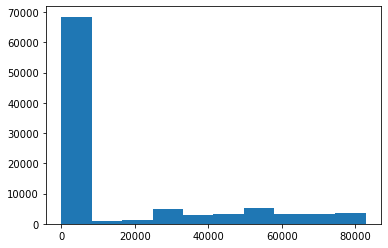

In [118]:
#sesgos de la variable hora2
plt.hist(df.hora2)

In [119]:
#limpieza de la variable hora2
#quitaremos los sesgos de las horas, nos quedaremos con aquellas horas de 24. 
df = df[df['hora2'].isin([i for i in range(1,24)])]
df.rename(columns ={'hora2': 'hora'}, inplace=True)

(array([ 3749.,  2261.,  4594.,  8178.,  6758., 10011.,  7552.,  7072.,
         6651.,  7970.]),
 array([ 1. ,  3.2,  5.4,  7.6,  9.8, 12. , 14.2, 16.4, 18.6, 20.8, 23. ]),
 <BarContainer object of 10 artists>)

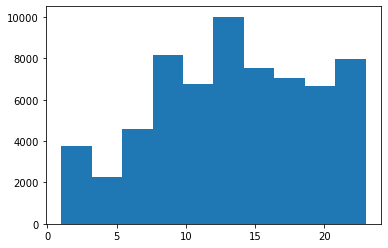

In [120]:
plt.hist(df.hora)

In [121]:
# limpieza de la variable mes:
df['aux'] = df['mes'].apply(lambda x:x.upper())
df = df.drop(['mes'],axis=1)
df.rename(columns = {'aux':'mes'}, inplace=True)

In [122]:
df['year'] = pd.to_datetime(df['fecha_evento']).dt.to_period('Y')

C:\Users\XMX5634\AppData\Local\Temp/ipykernel_20404/1187084835.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['year'] = pd.to_datetime(df['fecha_evento']).dt.to_period('Y')


# EXPLORACION DE DATOS

In [ ]:
tabla_frecuencias(df,'parte_dia')

In [ ]:
u = con_categ_to_columns(df,'parte_dia','fecha_mensual')

In [ ]:
fig = px.line(u, x='fecha', y=u.columns,
              hover_data={"fecha": "|%B %d, %Y"},
              title='Histórico del comportamiento de los sucesos en las 4 partes del dia',
             width=1300, height=400)
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()

Se puede observar que de manera general hay una distribución muy homogenea de como se comportan los eventos por hora, desde las 7am hasta las 21 pm, conforme las horas van pasando, van decreciendo los eventos.

por las madrugradas es cuando menos accidentes ocurren entre la 1 y 7 am, suelen ser bajos los sucesos activos. 

De manera histórica suelen haber mas accidentes por las tardes, su comportamiento es muy homogeneo tambíen, aunque en el ultimo trimestre del 2022 hubo una alza en las 4 partes del dia, a comparación de otros periodos. 

In [ ]:
u = con_categ_to_columns(df,'tipo_de_evento','fecha_mensual')

In [ ]:
fig = px.line(u, x='fecha', y=u.columns,
              hover_data={"fecha": "|%B %d, %Y"},
              title='Histórico de los eventos ocurridos en CDMX, de manera mensual.',
             width=1300, height=400)
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()

Se observa que por encima de todos, los CHOQUES ocurren en mayor medida, cada uno de los eventos ha seguido las mismas tendencias, con pequeñas excepciones donde hay pequeños o grandes aumentos.

Se destaca que los CHOQUES ocurrieron en mayor proporción en el último trimestre del 2022 respecto a su histórico, pero no es un comportamiento ciclico, en años anteriores en el mismo trimestre nunca se había visto este aumento tan significativo, los DERRAPOS y los ATROPPELLOS también tuvieron un comportamiento similar en este último trimestre del 2022. 

Será interesante analizar este último trimestre y ver las razones del porque estan ocurriendo mas los eventos.

In [ ]:
aux1 = pd.DataFrame(df.groupby(['year','mes'])['tipo_de_evento'].count()).reset_index()

In [ ]:
tabla_frecuencias(df,'tipo_de_evento')

Se observa que el 90% de los accidentes de tránsito que ocurren en la CDMX son por causas como CHOQUES, ATROPELLOS Y DERRAPOS, en donde el 56% son provocados por CHOQUES. 

Valdria la pena revisar estas tres categorías por separado y las ultimas 3 en conjunto (CAIDA DE CICLISTA, VOLCADURA Y CAIDA DE PASAJERO) ya que aproximadamente el 5% del total, son accidentes de este estilo. 

## Análisis Urbano
### de lo general a lo particular

In [ ]:
aux = pd.DataFrame(df.groupby(['alcaldia','tipo_de_evento'])['total_occisos','total_lesionados'].sum()).reset_index()

In [ ]:
plt.figure(figsize = (15,10))
sns.barplot(y = 'alcaldia', x = 'total_occisos',hue='tipo_de_evento',data=aux.sort_values('total_occisos', ascending = False))
plt.title('Total de Muertos por Alcaldía')

In [ ]:
plt.figure(figsize = (15,10))
sns.barplot(y = 'alcaldia', x = 'total_lesionados',hue='tipo_de_evento', data=aux.sort_values('total_lesionados', ascending = False))
plt.title('Total de Lesionados por Alcaldía')

In [ ]:
aux = pd.DataFrame(df.groupby(['alcaldia','involucrado','tipo_de_evento'])['total_occisos','total_lesionados'].sum()).reset_index()

In [ ]:
plt.figure(figsize = (15,10))
sns.barplot(y = 'alcaldia', x = 'total_occisos',hue='involucrado',data=aux.sort_values('total_occisos', ascending = False))

In [ ]:
plt.figure(figsize = (15,10))
sns.barplot(y = 'alcaldia', x = 'total_lesionados',hue='involucrado',data=aux.sort_values('total_lesionados', ascending = False))

Analisis:

Lesionados:
* Cuauhtemoc, Iztapalapa y Gustavo A. Madero las alcaldias que mas lesiones presentan.
* De manera general en todas alcaldias, ocurren mas las lesiones por CHOQUES.
* Atropellos y Derrapos suelen ocurrir con la misma frecuencia. 
* Caida de Ciclista,Volcadura y Caida de Pasajero ocurren de igual manera con la misma frecuencia y en menores proporciones
* Suelen lesionarse mas Hombres que Mujeres en todas las alcaldias. 

Muertos:
* Tlalpan, Iztapalapa y Gustavo A. Madero las alcaldias que mas muertes presentan.
* Las muertes por atropellos sobrepasan en Venustiano Carranza e Iztacalco.
* Suelen morir mas Hombres que Mujeres en todas las alcaldias.

**target 1 = ¿Cuales son las condiciones en las que mueren y se lesionan mas los Hombres por choques en Iztapalapa, Gustavo A.Madero, Tlalpan y Cuauhtemoc?**

**target 2 = ¿Cuales son las condiciones por las que mueren mas Hombres atropellados en Venustiando Carranza e Iztacalco?**

In [ ]:
targ_1 = df[(df['involucrado'] == 'masculino') & (df['tipo_de_evento'] == 'CHOQUE') & (df['alcaldia'].isin(['GUSTAVO A MADERO','TLALPAN','CUAUHTEMOC','IZTAPALAPA'])) ]

In [ ]:
aux = pd.DataFrame(targ_1.groupby(['alcaldia','colonia'])['total_occisos','total_lesionados'].sum()).reset_index()

In [ ]:
lesionados_ = []
occisos_ = []
for alc in aux.alcaldia.unique():
    lesionados = aux[aux['alcaldia'] == alc][['alcaldia','colonia','total_lesionados']].sort_values('total_lesionados', ascending = False)
    les = lesionados.iloc[0:10,:]
    occisos = aux[aux['alcaldia'] == alc][['alcaldia','colonia','total_occisos']].sort_values('total_occisos', ascending = False)
    occs = occisos.iloc[0:10,:]
    lesionados_.append(les)
    occisos_.append(occs)
    
df_les = pd.concat(lesionados_, axis = 0, ignore_index = True).sort_values('total_lesionados')
df_occi = pd.concat(occisos_, axis = 0, ignore_index = True).sort_values('total_occisos')

In [ ]:
plt.figure(figsize = (15,10))
sns.lineplot(x='total_lesionados', y='colonia', data = df_les, color='red')

* Juan Escutia, Roma Sur, Leyes de Reforma 3a Secc, Sta Maria la Ribera, Guerrero, Obrera, Roma Nte, Doctores y Centro son todas colonias donde los hombres se lesionan mas por CHOQUES > 200.

In [ ]:
plt.figure(figsize = (15,10))
sns.lineplot(x='total_occisos', y='colonia', data = df_occi, color='black')

* Leyes de Reforma 3a Seccion, El Paraiso, Morelos, San Felipe de Jesus, Juan Escutia, Area Fed Central de Abastos, San Andres Totoltepec, San Miguel Topilejo, Centro, Rusticia Tlalpan y Doctores son las colonias en donde mas hombres mueren  a causa de un choque > 5. 

In [ ]:

aux = pd.DataFrame(targ_1.groupby(['occiso'])['total_occisos'].sum()).reset_index()

In [ ]:
plt.figure(figsize=(10,10))
colors = sns.color_palette('bright')
plt.pie(aux.total_occisos, labels=aux.occiso ,colors = colors, autopct = '%0.0f%%')
plt.title('Indentidad de las personas involucradas en las muertes por CHOQUES en CDMX')
plt.show()

Los pasajeros son quienes mas fallecen por CHOQUES en CDMX correspondiente a un 12%, seguido de los Motoclistas con un 10% y en tercer lugar los conductores con un 7% 

In [ ]:
aux = pd.DataFrame(targ_1.groupby(['lesionado'])['total_lesionados'].sum()).reset_index()

In [ ]:
aux

In [ ]:
plt.figure(figsize=(10,10))
colors = sns.color_palette('bright')
plt.pie(aux.total_lesionados, labels=aux.lesionado ,colors = colors, autopct = '%0.0f%%')
plt.title('Indentidad de las personas involucradas en lesiones por CHOQUES en CDMX')
plt.show()

Los Motociclistas son las personas que mas se lesionan por CHOQUES, correspondiente al 18% de lesiones, seguido de los Conductores con un 12% y al finaal los Pasajores con un 10%. 


In [ ]:
aux = targ_1[targ_1['colonia'].isin(df_les.colonia.unique())]

In [ ]:
plt.figure(figsize=(15,10))
sns.boxplot(y = 'colonia', x = 'hora', data=aux)
plt.title('Distribución de Horas por Colonia')

Se observa que la hora en la que suceden los sucesos por CHOQUES (Muertos y Lesionados), suelen ser muy similares en todas las alcaldías, incluso tomando las horas mínimas y máximas. 

Todas poseen una mediana entre las 12 y las 16 horas, el 50% de los sucesos de cada alcaldía ocurren enntre casi las mismas horas. 

# PREPROCESAMIENTO DE DATOS

### Ordinal Encode

In [123]:
dicc_mes = {'ENERO':1,'FEBRERO':2,'MARZO':3,'ABRIL':4,'MAYO':5,'JUNIO':6,'JULIO':7,'AGOSTO':8,'SEPTIEMBRE':9,'OCTUBRE':10,'NOVIEMBRE':11,'DICIEMBRE':12}
df['mes_aux'] = df['mes'].map(dicc_mes)
df = df.drop(columns = ['mes'], axis=1)
df.rename(columns = {'mes_aux':'mes'}, inplace=True)

In [124]:
df['dia_aux'] = df['dia'].map(dict(zip(['LUNES','MARTES','MIERCOLES','JUEVES','VIERNES','SABADO','DOMINGO'],[i for i in range(1,8)])))
df = df.drop(columns = ['dia'], axis=1)
df.rename(columns = {'dia_aux':'dia'}, inplace=True)

In [125]:
df['prioridad_aux'] = df['prioridad'].map({'BAJA':1,'MEDIA':2, 'ALTA':3})
df = df.drop(columns = ['prioridad'], axis=1)
df.rename(columns = {'prioridad_aux':'prioridad'}, inplace=True)

In [126]:
fechas = df['year'].astype(str) + "-" + df['mes'].astype(str) + "-" + '01'
df['fecha_mensual'] = pd.to_datetime(fechas)

### Dummies

In [127]:
cols_dummies = ['tipo_de_evento','alcaldia','involucrado','interseccion_semaforizada']

In [128]:
df_dummies = pd.get_dummies(data=df,columns=cols_dummies)

### Frecuency Encoding 

In [129]:
cols_frecuency = ['colonia','tipo_de_interseccion','unidad_medica_de_apoyo','occiso','lesionado','tipo_de_vehiculo_1',
                 'marca_de_vehiculo_1','color_vehiculo_1','tipo_de_vehiculo_2','marca_de_vehiculo_2','color_vehiculo_2',
                 'clasificacion_de_la_vialidad']

In [130]:
names = []
for col in cols_frecuency:
    
    #encoder_1 = ce.CountEncoder(cols=col)
    #name_count = col + '_count_encouded'
    #df_dummies[name_count] = encoder_1.fit_transform(df_dummies[col])
    
    # -------------------------------------------------------------
    encoder_2 = ce.CountEncoder(cols=col, normalize=True)
    name_frecuency = col + '_frequency_encouded'
    df_dummies[name_frecuency] = encoder_2.fit_transform(df_dummies[col])
    names.append(name_frecuency)
    df_dummies = df_dummies.drop([col], axis=1)

In [131]:
# borrar def al final 
drop_final = ['no_folio','fecha_evento','year','parte_dia','punto_1','punto_2','sentido_de_circulacion','fecha_mensual']
df_dummies = df_dummies.drop(drop_final,axis=1)

In [139]:
df_dummies

,hora,total_occisos,total_lesionados,mes,dia,prioridad,tipo_de_evento_ATROPELLADO,tipo_de_evento_CAIDA DE CICLISTA,tipo_de_evento_CAIDA DE PASAJERO,tipo_de_evento_CHOQUE,...,unidad_medica_de_apoyo_frequency_encouded,occiso_frequency_encouded,lesionado_frequency_encouded,tipo_de_vehiculo_1_frequency_encouded,marca_de_vehiculo_1_frequency_encouded,color_vehiculo_1_frequency_encouded,tipo_de_vehiculo_2_frequency_encouded,marca_de_vehiculo_2_frequency_encouded,color_vehiculo_2_frequency_encouded,clasificacion_de_la_vialidad_frequency_encouded
60356,4.0,0,1,12,7,1,1,0,0,0,...,0.046145,0.991357,0.121983,0.059494,0.354976,0.713624,0.441802,0.478641,0.713624,0.475353
50703,7.0,0,1,2,2,1,0,0,0,1,...,0.150935,0.991357,0.168513,0.344836,0.004213,0.713624,0.099852,0.016699,0.713624,0.475353
7181,8.0,0,1,2,2,1,1,0,0,0,...,0.150935,0.991357,0.121983,0.046315,0.018581,0.713624,0.441802,0.478641,0.713624,0.475353
7182,8.0,0,1,2,2,1,1,0,0,0,...,0.172588,0.991357,0.121983,0.344836,0.018581,0.713624,0.441802,0.478641,0.713624,0.475353
61063,8.0,0,1,2,2,1,1,0,0,0,...,0.308908,0.991357,0.121983,0.344836,0.354976,0.713624,0.441802,0.478641,0.713624,0.475353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60492,10.0,0,1,12,1,1,0,0,0,1,...,0.308908,0.991357,0.072597,0.344836,0.004537,0.713624,0.009615,0.179409,0.713624,0.475353
82740,4.0,1,0,9,5,3,1,0,0,0,...,0.000864,0.991357,0.532409,0.344836,0.001744,0.713624,0.441802,0.478641,0.713624,0.040836
82475,14.0,0,1,9,5,1,0,0,0,1,...,0.150935,0.991357,0.532409,0.399747,0.354976,0.095129,0.244228,0.000015,0.094975,0.135518
71077,8.0,0,2,3,5,1,0,0,0,1,...,0.150935,0.991357,0.532409,0.399747,0.354976,0.095129,0.244228,0.179409,0.094975,0.154732


### ACP

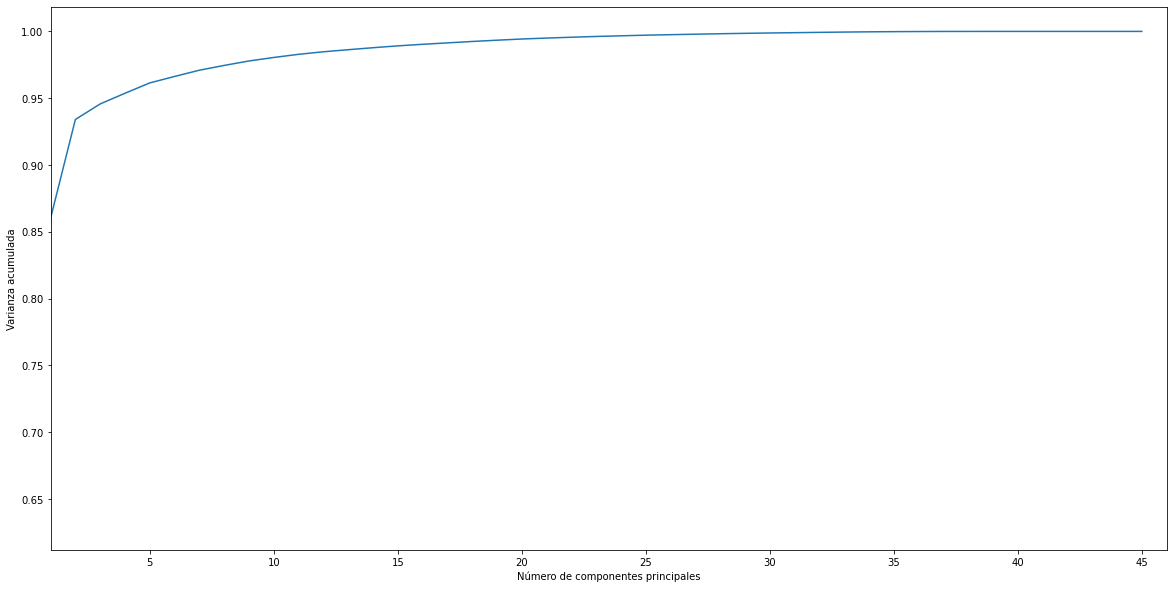

In [133]:
# Inicializar PCA y ajustar a los datos
pca = PCA().fit(df_dummies)

# Obtener la varianza explicada de cada componente principal
variance = pca.explained_variance_ratio_

# Obtener la varianza acumulada de los componentes principales
cumulative_variance = np.cumsum(variance)

# Graficar la varianza acumulada
plt.figure(figsize=(20,10)) 
plt.plot(cumulative_variance)
plt.xlabel('Número de componentes principales')
plt.xlim(1,pca.n_components_)
plt.ylabel('Varianza acumulada')
plt.show()

In [137]:
# Componente principal asociado al 84% de la varianza explicada. 
i = 1
dicc = {}
for cum_var in cumulative_variance:
    if 0.8 <= cum_var:
        dicc[i] = cum_var
        break
    i += 1
print(dicc)

{2: 0.8601459465254758}


In [138]:
pca = PCA(n_components = 2)
principal_comp = pca.fit_transform(df_dummies)
principal_comp

array([[ 9.26861845, -5.29233726],
       [ 6.38993528,  4.7729705 ],
       [ 5.38056696,  4.79093759],
       ...,
       [-0.70546864, -2.08401261],
       [ 5.41747758,  3.7921552 ],
       [11.41139409,  3.67616937]])

In [140]:
dicc = {}
for i in range(1,3):
    pca = 'PCA'+str(i)
    dicc[pca] = principal_comp[:,i-1]
    
df_pca = pd.DataFrame(dicc)

In [143]:
df_pca

,PCA1,PCA2
0,9.268618,-5.292337
1,6.389935,4.772971
2,5.380567,4.790938
3,5.381919,4.789387
4,5.384572,4.790201
...,...,...
64791,3.171929,-5.164589
64792,9.297204,-2.281119
64793,-0.705469,-2.084013
64794,5.417478,3.792155


In [142]:
df_pca.to_csv('C:/Users/XMX5634/Documents/Hechos-de-Transito-registrados-por-la-SSC/pca.csv',index=False)

In [147]:
np.random.seed(10)
train, test = train_test_split(df_pca, train_size = 0.7, random_state = 0)

In [148]:
train.to_csv('C:/Users/XMX5634/Documents/Hechos-de-Transito-registrados-por-la-SSC/pca_train.csv',index=False)

In [149]:
test.to_csv('C:/Users/XMX5634/Documents/Hechos-de-Transito-registrados-por-la-SSC/pca_test.csv',index=False)

C:\Users\XMX5634\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\XMX5634\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\XMX5634\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\XMX5634\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the w

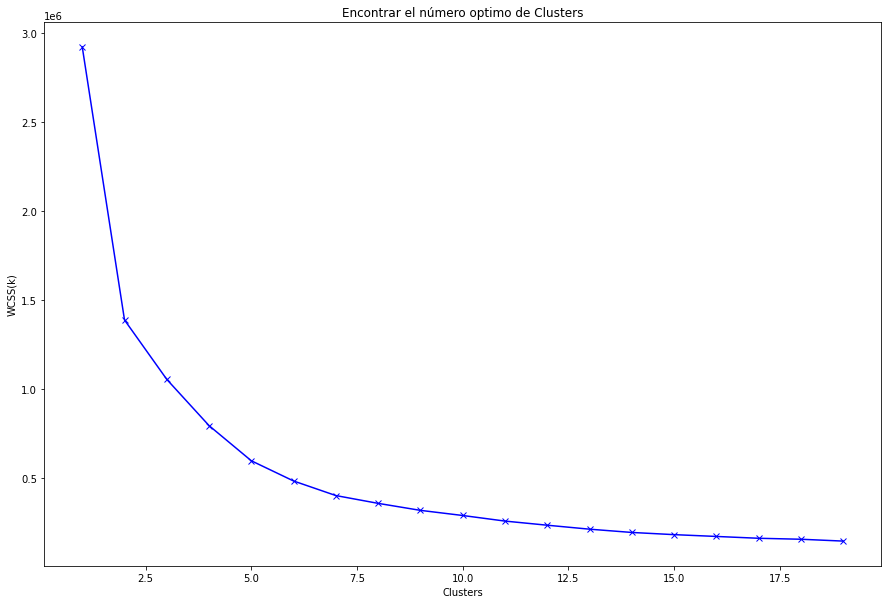

In [164]:
#aplicamos ahora si el metodo del codo. 
scores_1 = [] #aqui acumularemos todas las sumas al cuadrado.  
range_values = range(1,20)

for i in range_values: 
    kmeans = KMeans(n_clusters = i) #lo que hace esto es crear el modelo de k-means, para el dataset normalizado, junto 
    kmeans.fit(df_pca) #con esta linea, para cada i, hará su propio cluster de k-means. 
    scores_1.append(kmeans.inertia_) #una vez completados todos ellos, lo que interesa es la suma de los cuadrados intracluster
                                    #parametro, llamado inertia.
plt.figure(figsize = (15,10))
plt.plot(range_values, scores_1, 'bx-')
plt.title("Encontrar el número optimo de Clusters")
plt.xlabel("Clusters")
plt.ylabel("WCSS(k)")
plt.show()

## Aplicar K-Means

In [178]:
kmeans = KMeans(4) #numero de clusters
kmeans.fit(df_pca)
labels = kmeans.labels_

C:\Users\XMX5634\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [179]:
labels

array([2, 0, 0, ..., 2, 0, 0])

In [180]:
kmeans.cluster_centers_.shape 

(4, 2)

In [181]:
kmeans.cluster_centers_ # Centroides de cada clase. 

array([[ 6.97437601,  2.05225433],
       [-5.72767626, -2.42998113],
       [ 3.03496007, -2.77821335],
       [-3.47229426,  3.46960518]])

In [182]:
#si nos quedamos con el centros y visualizarnos de una forma mas comoda. 
clusters_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [df_pca.columns])
clusters_centers
#para cada uno de los 6 clusters, desde el cluster 0 hasta el 5, podemos ver donde estaria el centro, cada fila representa uno 
#de los centroides y en cada columna donde se encuentra la coordenada en cuestión.

#podemos fijarnos un poco en cuales son las tendencias, 

,PCA1,PCA2
0,6.974376,2.052254
1,-5.727676,-2.429981
2,3.034960,-2.778213
3,-3.472294,3.469605


In [183]:
#si nos quedamos con el centros y visualizarnos de una forma mas comoda. 
clusters_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [df_pca.columns])
clusters_centers
#para cada uno de los 8 clusters, desde el cluster 0 hasta el 7, podemos ver donde estaria el centro, cada fila representa uno 
#de los centroides y en cada columna donde se encuentra la coordenada en cuestión.

#podemos fijarnos un poco en cuales son las tendencias, 

,PCA1,PCA2
0,6.974376,2.052254
1,-5.727676,-2.429981
2,3.034960,-2.778213
3,-3.472294,3.469605


In [184]:
pca_df = pd.concat([df_pca, pd.DataFrame({'cluster':labels})], axis = 1)

In [185]:
pca_df

,PCA1,PCA2,cluster
0,9.268618,-5.292337,2
1,6.389935,4.772971,0
2,5.380567,4.790938,0
3,5.381919,4.789387,0
4,5.384572,4.790201,0
...,...,...,...
64791,3.171929,-5.164589,2
64792,9.297204,-2.281119,0
64793,-0.705469,-2.084013,2
64794,5.417478,3.792155,0


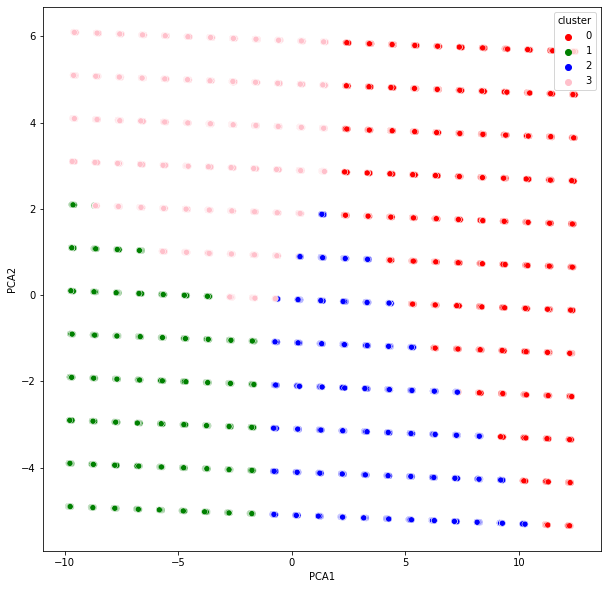

In [187]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x = "PCA1", y = "PCA2", hue = "cluster", data = pca_df, 
                    palette = ["red", "green", "blue", "pink"])
plt.show()
#todos los puntos del mismo color, pertenecen al mismo cluster. 
#el kmeans no ha sido aplicado a este espacio bidimensional, no a las cp, sino a las obs originales, una vez aplicadas
#solo proyectamos en un espacio de dimension 2.